# Plotting results from a scan

You should run `rsopt sample configuration config_madx.yml` in the command line before running this notebook.

This will execute a parameter scan that varies the quadrupole strength (K1) of the UQ3 and UQ12 quadrupoles over a range of values. This notebook shows how to load the scan data using the utilities included with rsopt.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sirepo.template import madx_parser
from rsopt.libe_tools import analysis

# Load Results 

We will load the Twiss file `twiss.file.tfs` for each step in the scan and plot an example of the output

The `results` class from `rsopt.libe_tools.analysis` can load data from an rsopt job (optimization or sampling). The `results` class stores a series of `result` objects for each run in the job. Each `result` maintains data about the parameters, results, and run status for that job. 

The `results` object pulls data from the YAML configuration file, libE_stats.txt, and the job directories. For completed jobs you can just git the path to the top level of the job directory, which will contain all these files. For jobs in progress or failed jobs you can pass the locations of these files and directories individually.

In [2]:
results = analysis.load_results('./madx_scan/')

## `results` object

Each `BaseResult` is automatically populated with attributes corresponding to the job parameter. Note: that you may need to use `getattr` for accelerator element names. The `results` object will function as an iterator.

In [3]:
for res in results:
    print(f"Simulation {res.sim_id} UQ3.K1 strength:", getattr(res, 'UQ3.K1'))

Simulation 0 UQ3.K1 strength: 0.0
Simulation 1 UQ3.K1 strength: 0.5
Simulation 2 UQ3.K1 strength: 1.0
Simulation 3 UQ3.K1 strength: 0.0
Simulation 4 UQ3.K1 strength: 0.5
Simulation 5 UQ3.K1 strength: 1.0
Simulation 6 UQ3.K1 strength: 0.0
Simulation 7 UQ3.K1 strength: 0.5
Simulation 8 UQ3.K1 strength: 1.0
Simulation 9 UQ3.K1 strength: 0.0
Simulation 10 UQ3.K1 strength: 0.5
Simulation 11 UQ3.K1 strength: 1.0
Simulation 12 UQ3.K1 strength: 0.0
Simulation 13 UQ3.K1 strength: 0.5
Simulation 14 UQ3.K1 strength: 1.0


`BaseResult`s may also be queried by index. Though it is not guaranteed that the indices will align to `sim_id` if the jobs were performed asynchronously or requried restarts.

In [4]:
results[2]

Result(sim_id=2, sim_worker=1, sim_ended=True, sim_started=True, f=nan, fvec=None, base_path=PosixPath('madx_scan'), UQ3.K1=1.0, UQ12.K1=-0.125)

## Loading simulations results

The file path to each job directory is automatically constructed and returned as a `pathlib.Path`. This can be used to load in results from each job. You may define new attributes for `BaseResults` as long as they do not clash with an existing name. This can be used to associate loaded data with the job for plotting and processing.

In [5]:
# Simulation file to be loaded from each job directory
twiss_file_name = 'twiss.file.tfs'

In [6]:
for res in results:
    
    # If you are looking at an ongoing run the sim_ended flag can be checked to filter out incomplete jobs.
    if res.sim_ended:
        _tfs_file = madx_parser.parse_tfs_file(
            res.path.joinpath(twiss_file_name)
        )
        
        # Define a new attribute `twiss` for each BaseResult and store the loaded file data there
        res.twiss = _tfs_file
        
    else:
        print(f'{res.sim_id} still running')
    

# Plotting

`range_query` can be used to select from `results` based on the values of a parameter

In [7]:
results.range_query('UQ3.K1', low=0.0, high=0.07)

[Result(sim_id=0, sim_worker=1, sim_ended=True, sim_started=True, f=nan, fvec=None, base_path=PosixPath('madx_scan'), UQ3.K1=0.0, UQ12.K1=-0.125),
 Result(sim_id=3, sim_worker=1, sim_ended=True, sim_started=True, f=nan, fvec=None, base_path=PosixPath('madx_scan'), UQ3.K1=0.0, UQ12.K1=-0.0625),
 Result(sim_id=6, sim_worker=1, sim_ended=True, sim_started=True, f=nan, fvec=None, base_path=PosixPath('madx_scan'), UQ3.K1=0.0, UQ12.K1=0.0),
 Result(sim_id=9, sim_worker=1, sim_ended=True, sim_started=True, f=nan, fvec=None, base_path=PosixPath('madx_scan'), UQ3.K1=0.0, UQ12.K1=0.0625),
 Result(sim_id=12, sim_worker=1, sim_ended=True, sim_started=True, f=nan, fvec=None, base_path=PosixPath('madx_scan'), UQ3.K1=0.0, UQ12.K1=0.125)]

As an example we plot $\beta_x$ from each step in the scan. The value of the quadrupole UQ12 being varied at each step can be retrieved from the history array using the 'x' field (H['x']). 

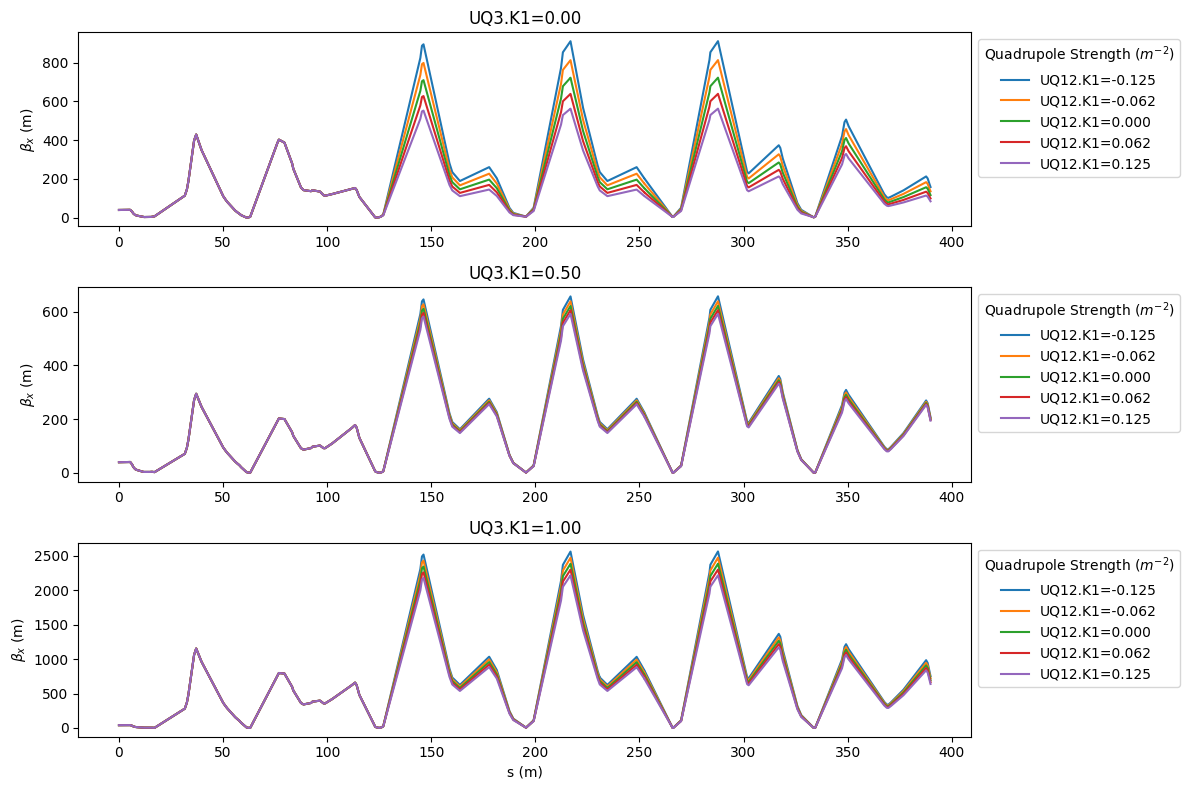

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8))


for ax, uq3k1 in zip(axes, np.linspace(0, 1, 3)):
    res_list = results.range_query('UQ3.K1', low=uq3k1*0.999, high=uq3k1*1.0001)
    ax.set_title(f'UQ3.K1={uq3k1:0.2f}')
    for res in res_list:
        ax.plot(np.array(res.twiss['s'], float), np.array(res.twiss['betx'], float), label='UQ12.K1={:0.3f}'.format(getattr(res, 'UQ12.K1')))

    ax.legend(title=r'Quadrupole Strength ($m^{-2}$)', bbox_to_anchor=(1, 1))
    ax.set_ylabel(r'$\beta_x$ (m)')
    
axes[-1].set_xlabel('s (m)')
plt.tight_layout()
plt.show()